##### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import imageio
from PIL import Image
import ipyplot
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support as score, precision_score, recall_score, f1_score
import pathlib
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB

### DO NOT RUN BELOW YOU NEED TO HAVE THE 158 GB FOLDER
* I am using a subset of data from the 158 GB dataset

##### Exploring the data

In [ ]:
data_dir = "../input/hpa-single-cell-image-classification/train"
data_dir = pathlib.Path(data_dir)

In [ ]:
image_count = os.listdir(data_dir)
len(image_count)

In [ ]:
df_train = pd.read_csv("../input/hpa-single-cell-image-classification/train.csv")
df_train.head()

In [ ]:
train_images = "../input/hpa-single-cell-image-classification/train"
train_images = os.listdir(train_images)

### Note
*  the following code below shows that there are 4 images in the train folder assoicated with the image ID that corresponds to Red, Blue, Green, and Yellow channels...In other words, 4 images per ID that are differentiated by color (Red, Blue, Green, Yellow)

In [ ]:
len(df_train), len(train_images), len(train_images)/len(df_train)

##### Number of labels per images
* We can see that there are more than 10,000 images that are composed of 1 label out of the 18 labels so due to space constraints we will stick with the 1 label images

In [ ]:
df_train['num_classes'] = df_train['Label'].apply(lambda r: len(r.split('|')))
df_train['num_classes'].value_counts().plot.bar(title='Examples with multiple labels', xlabel='number of labels per example', ylabel='# train examples')
plt.show()

##### Things to keep in mind regarding channels
* Red (Microtubules)
* Green (Protein of interest)
* Blue (Nucleus)
* Yellow (Endoplasmic reticulum)

##### Here we seperate the images based on the ID and color

In [ ]:
path = "../input/hpa-single-cell-image-classification"
mt = [path+'/train/'+(id+'_red.png') for id in df_train.ID.values]
er = [path+'/train/'+(id+'_yellow.png') for id in df_train.ID.values]
nu = [path+'/train/'+(id+'_blue.png') for id in df_train.ID.values]
pr = [path+'/train/'+(id+'_green.png') for id in df_train.ID.values]
images = [mt, er, nu, pr]
titles = ['microtubules', 'endoplasmic reticulum', 'nucleus', 'protein of interest']

##### Viewing the images 
* Images by themselves (no stack)

In [ ]:
fig, ax = plt.subplots(3,4, figsize=(20,12))
for j in range(3):
    for i in range(4):
        img = plt.imread(images[i][j])
        if j == 0: ax[j,i].set_title(titles[i])
        ax[j,i].imshow(img)
        ax[j,i].axis('off')
plt.show()

##### Generating stacked Images
* These are images stacked (red, yellow, blue)

In [ ]:
labels = [str(i) for i in range(19)]
class_images = []
for label in labels:
    r_img = df_train[df_train.Label == label].reset_index(drop=True).ID.loc[0] + '_red.png'
    y_img = df_train[df_train.Label == label].reset_index(drop=True).ID.loc[0] + '_yellow.png'
    b_img = df_train[df_train.Label == label].reset_index(drop=True).ID.loc[0] + '_blue.png'
    r = imageio.imread(path+'/train/'+r_img)
    y = imageio.imread(path+'/train/'+y_img)
    b = imageio.imread(path+'/train/'+b_img)
    rgb = np.dstack((r,y,b))
    class_images.append(PIL.Image.frombytes('RGB',r.shape,rgb))

codes = [
'0. Nucleoplasm',
'1. Nuclear membrane',
'2. Nucleoli',
'3. Nucleoli fibrillar center',
'4. Nuclear speckles',
'5. Nuclear bodies',
'6. Endoplasmic reticulum',
'7. Golgi apparatus',
'8. Intermediate filaments',
'9. Actin filaments',
'10. Microtubules',
'11. Mitotic spindle',
'12. Centrosome',
'13. Plasma membrane',
'14. Mitochondria',
'15. Aggresome',
'16. Cytosol',
'17. Vesicles and punctate cytosolic patterns',
'18. Negative'
]

ipyplot.plot_images(images=class_images, labels=codes, max_images=19, img_width=300)

##### Generating directories and saving images with respect to the labels associated to the images

In [ ]:
# 25 images 
img_counter = list(range(25))
# per label 
labels = [str(i) for i in range(19)]
code = [
'00_Nucleoplasm',
'01_Nuclear_membrane',
'02_Nucleoli',
'03_Nucleoli_fibrillar_center',
'04_Nuclear_speckles',
'05_Nuclear_bodies',
'06_Endoplasmic_reticulum',
'07_Golgi_apparatus',
'08_Intermediate_filaments',
'09_Actin_filaments',
'10_Microtubules',
'11_Mitotic_spindle',
'12_Centrosome',
'13_Plasma_membrane',
'14_Mitochondria',
'15_Aggresome',
'16_Cytosol',
'17_Vesicles_and_punctate_cytosolic_patterns',
'18_Negative'
]

for label in labels:
    print("Generating Images for "+code[int(label)] )
    for i in img_counter:
        try:
            r_img = df_train[df_train.Label == label].reset_index(drop=True).ID.loc[i] + '_red.png'
            y_img = df_train[df_train.Label == label].reset_index(drop=True).ID.loc[i] + '_yellow.png'
            b_img = df_train[df_train.Label == label].reset_index(drop=True).ID.loc[i] + '_blue.png'
            name = df_train[df_train.Label == label].reset_index(drop=True).ID.loc[i]

            r = imageio.imread(path+'/train/'+r_img)
            y = imageio.imread(path+'/train/'+y_img)
            b = imageio.imread(path+'/train/'+b_img)
            rgb = np.dstack((r,y,b))
            image_name = PIL.Image.frombytes('RGB',r.shape,rgb)


            if not os.path.exists("data/"+code[int(label)]):
                os.makedirs("data/"+code[int(label)])

            image_name.save("data/"+code[int(label)]+"/"+ name + ".png")
        except:
            print("Unable to save image with this label: "+ code[int(label)])
    
    print("Completed Generating Images for "+code[int(label)] )


### RUN ALL BELOW

##### Size of images and batch size variables

In [2]:
batch_size = 32
img_height = 180
img_width = 180

##### Training Data Generator

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
 "./data",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10412 files belonging to 19 classes.
Using 8330 files for training.


##### Validation Data Generator

In [4]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "./data",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10412 files belonging to 19 classes.
Using 2082 files for validation.


##### Training Data

In [5]:
x_train = list()
y_train = list()
for raw_data,labels in train_ds:
    y_train.extend(np.array(labels))
   # print(labels)
    for image_data_per in raw_data:
        x_train.append(np.array(image_data_per))
x_train = np.array(x_train).reshape(-1,(180*180*3))
#print(x_train.shape)
y_train = np.array(y_train)
#print(y_train.shape)

##### Validation data

In [6]:
x_test = list()
y_test = list()
for raw_data,labels in val_ds:
    y_test.extend(np.array(labels))
    #print(labels)
    for image_data_per in raw_data:
        x_test.append(np.array(image_data_per))
x_test = np.array(x_test).reshape(-1,(180*180*3))
#print(x_test.shape)
y_test = np.array(y_test)
#print(y_test.shape)

**Create functions to create multi-label AUC_ROC curve**

In [7]:
import sklearn.metrics as metrics
import seaborn as sns
def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    y_score = clf.decision_function(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    label_ = dict(code)
    
    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (AUC = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

In [8]:
def plot_multiclass_roc_advanced(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    y_score = clf.predict_proba(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (AUC = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

##### Feature Engineering
* Stacking the images so that they are able to express the protein of interest along with their landmarks
* StandardScaler the pixel values from 0-255 range to 0-1 range, ImageDataGenerator class can be used. The range in 0-1 scaling is known as Normalization.

##### SVM Classifer

In [9]:
pipe = make_pipeline(StandardScaler(), GaussianNB())
pipe.fit(x_train, y_train)
y_pred = pipe.predict(x_test)
print(classification_report(y_test,y_pred))
precision = precision_score(y_test, y_pred,average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred,average='weighted')
print('Recall: %f' % recall)
# f1: tp / (tp + fp + fn)
f1 = f1_score(y_test, y_pred,average='weighted')
print('F1 score: %f' % f1)

              precision    recall  f1-score   support

           0       0.28      0.21      0.24       301
           1       0.03      0.02      0.02        56
           2       0.09      0.03      0.04       108
           3       0.05      0.01      0.02        98
           4       0.12      0.07      0.09       176
           5       0.09      0.11      0.10       128
           6       0.03      0.01      0.02       101
           7       0.19      0.04      0.06       141
           8       0.07      0.05      0.06        95
           9       0.04      0.07      0.05        59
          10       0.05      0.24      0.08        71
          12       0.04      0.02      0.02       116
          13       0.10      0.45      0.17       175
          14       0.17      0.02      0.04       217
          15       0.07      0.05      0.06        20
          16       0.06      0.02      0.03       167
          17       0.05      0.02      0.03        47
          18       0.08    

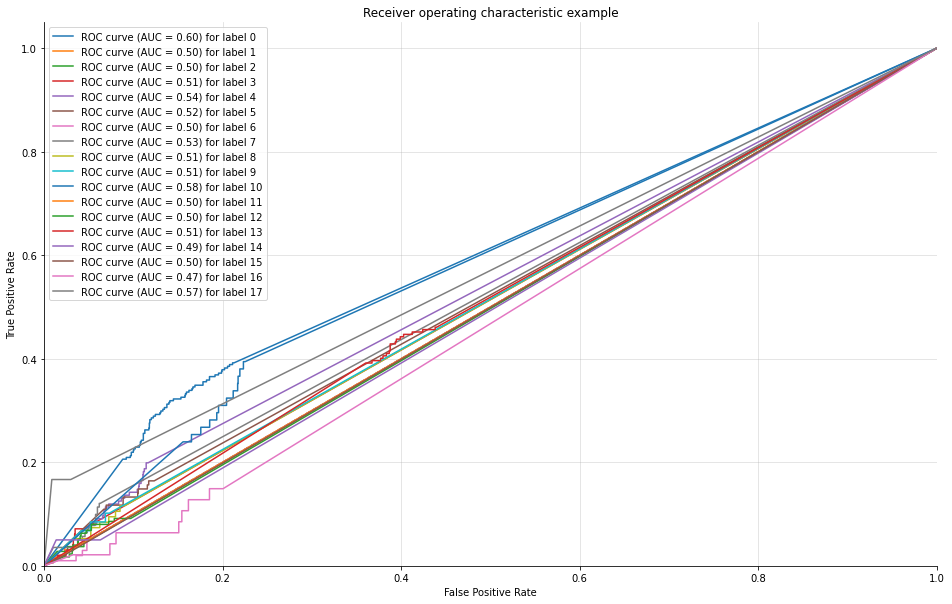

In [11]:
plot_multiclass_roc_advanced(pipe, x_test, y_test, n_classes=18, figsize=(16, 10))

##### Random Forest Classifer

In [11]:
pipe = make_pipeline(StandardScaler(), RandomForestClassifier())
pipe.fit(x_train, y_train)
y_pred = pipe.predict(x_test)
print(classification_report(y_test,y_pred))
precision = precision_score(y_test, y_pred,average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred,average='weighted')
print('Recall: %f' % recall)
# f1: tp / (tp + fp + fn)
f1 = f1_score(y_test, y_pred,average='weighted')
print('F1 score: %f' % f1)


              precision    recall  f1-score   support

           0       0.18      0.67      0.28       301
           1       0.00      0.00      0.00        56
           2       0.05      0.01      0.02       108
           3       0.24      0.06      0.10        98
           4       0.14      0.11      0.12       176
           5       0.10      0.05      0.07       128
           6       0.11      0.02      0.03       101
           7       0.20      0.11      0.14       141
           8       0.27      0.07      0.12        95
           9       0.50      0.02      0.03        59
          10       0.29      0.07      0.11        71
          12       0.11      0.03      0.04       116
          13       0.24      0.17      0.19       175
          14       0.12      0.18      0.14       217
          15       0.00      0.00      0.00        20
          16       0.28      0.14      0.19       167
          17       1.00      0.04      0.08        47
          18       0.00    

C:\Users\PScout\anaconda3\envs\py3_base\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PScout\anaconda3\envs\py3_base\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PScout\anaconda3\envs\py3_base\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\P

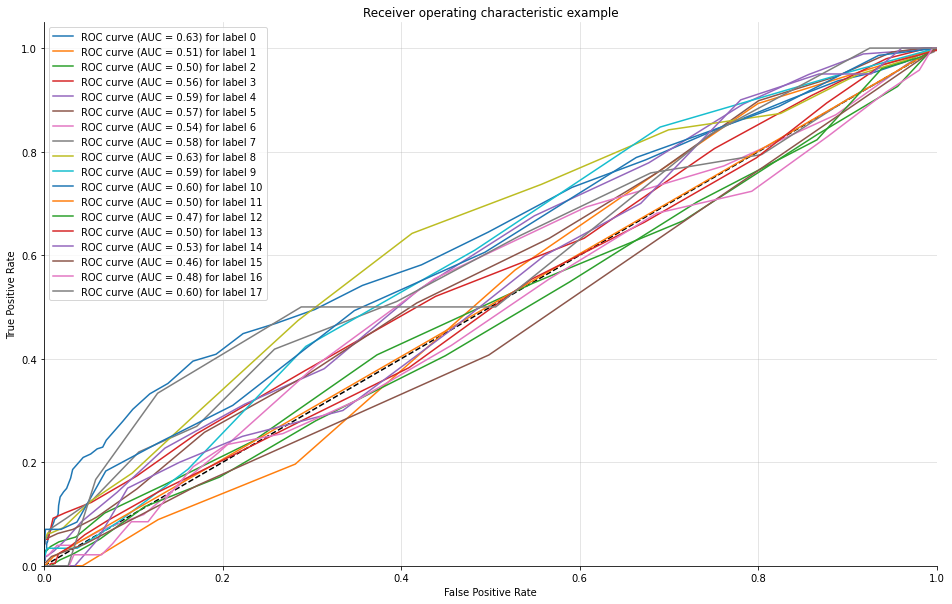

In [12]:
plot_multiclass_roc_advanced(pipe, x_test, y_test, n_classes=18, figsize=(16, 10))

#### XGBoost Classifer

In [ ]:
pipe = make_pipeline(StandardScaler(), XGBClassifier())
pipe.fit(x_train, y_train)
y_pred = pipe.predict(x_test)
print(classification_report(y_test,y_pred))
precision = precision_score(y_test, y_pred,average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred,average='weighted')
print('Recall: %f' % recall)
# f1: tp / (tp + fp + fn)
f1 = f1_score(y_test, y_pred,average='weighted')
print('F1 score: %f' % f1)

In [ ]:
plot_multiclass_roc_advanced(pipe, x_test, y_test, n_classes=18, figsize=(16, 10))